In [1]:
from astropy.table import Table, column, vstack
import astropy.units as u
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

In [2]:
galaxy_data = Table.read('s4g_fits/galaxy_data.fits')
bulge_disc_data = Table.read('s4g_fits/bulge_disc_matched.fits')
morph_data = Table.read('s4g_fits/buta_matched.fits')
psi_data = Table.read('s4g_fits/psi_matched.fits')

#### Sample selection

In [3]:
has_arms = np.any([morph_data['AC'] == b'G',morph_data['AC'] == b'M',
                   morph_data['AC'] == b'F'],axis=0)

In [4]:
has_arms

array([False,  True,  True, ..., False,  True, False], dtype=bool)

In [5]:
# Select a sample of spirals from the Buta+ classifications
morph_ok = np.all([morph_data['__T_'] >= 1,
                   morph_data['__T_'] <= 9],axis=0)

has_arms = np.any([morph_data['AC'] == b'G',morph_data['AC'] == b'M',
                   morph_data['AC'] == b'F'],axis=0)
unbarred = morph_data['__F_'] <= 0.25

# Type decompositions: only select galaxies with a clear disc
acceptable_types = ('bd','bdbar','bdbarf','dbar','dbarf',
                    'dn','bdbarfn','dbarfn','dbarn','dbarnf')
type_ok = np.any([bulge_disc_data['model'] == type_ 
                  for type_ in acceptable_types],axis=0)

bulge_disc_ok = (bulge_disc_data['f_bulge'] 
               + bulge_disc_data['f_disc']) >= 0.9
# ^ only selecting the disc galaxies
fit_ok = bulge_disc_data['quality'] == '5' # good fits only

# General catalogue properties
has_mass = np.isfinite(galaxy_data['m_tot'])
disc_ok = bulge_disc_data['R_d'] > 0
has_psi = psi_data['P_abs'] > 0

sample = np.all([morph_ok,has_arms,
                 type_ok,bulge_disc_ok,fit_ok,
                 has_mass,disc_ok],axis=0)
unbarred_sample = np.all([sample,unbarred],axis=0)
print('{}/{} galaxies with bulge+disc'.format(sample.sum(),len(sample)))
print('+ {} are unbarred'.format(unbarred_sample.sum()))

204/2352 galaxies with bulge+disc
+ 101 are unbarred


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less_equal


In [6]:
from halo import TotalHalo

m_tot = galaxy_data['m_tot'][sample] * u.Msun
delta_m_tot = galaxy_data['delta_m_tot'][sample] * u.Msun

m_b = bulge_disc_data['f_bulge'][sample].data * m_tot
m_b[m_b < 0] = 0
delta_m_b = bulge_disc_data['f_bulge'][sample].data * delta_m_tot
delta_m_b[delta_m_b < 0] = 0

m_d = bulge_disc_data['f_disc'][sample].data * m_tot
m_d[m_d < 0] = 0
delta_m_d = bulge_disc_data['f_disc'][sample].data * delta_m_tot
delta_m_d[delta_m_d < 0] = 0

a_b = bulge_disc_data['R_b'][sample].data * u.kpc
a_b[a_b < 0] = 0
delta_a_b = bulge_disc_data['delta_R_b'][sample].data * u.kpc
delta_a_b[a_b < 0] = 0

R_d = bulge_disc_data['R_d'][sample].data * u.kpc
R_d[R_d < 0] = 0
delta_R_d = bulge_disc_data['delta_R_d'][sample].data * u.kpc
R_d[delta_R_d < 0] = 0

halos = TotalHalo(m_b,delta_m_b,m_d,delta_m_d,a_b,delta_a_b,
                  R_d, delta_R_d, None, None)

In [7]:
class HistogramData():
    def __init__(self,data,data2,color,bins,log,alpha=0.3,color2='k'):
        self.data = data
        self.data2 = data2
        self.color = color
        self.bins = bins
        self.log = log
        self.alpha = alpha
        self.color2 = color2
        
    def histogram(self,ax):
        histdata = (np.log10(self.data.data) 
                    if self.log is True else self.data.data)
        _ = ax.hist(histdata,self.bins,
                    histtype='stepfilled',color=self.color,alpha=self.alpha)
        _ = ax.hist(histdata,self.bins,histtype='step',color=self.color)
        if self.data2 is not None:
            histdata2 = (np.log10(self.data2.data) 
                         if self.log is True else self.data2.data)
            _ = ax.hist(histdata2,self.bins,histtype='step',lw=3,color=self.color2)
            
    def uncertainty(self,data):
        if self.log is False:
            med_error = np.median(data.uncertainty.array)
        else:
            med_error = 0.434 * np.median(data.uncertainty.array
                                         /data.data)
        return med_error
        
            
    def uncertainty_bar(self,ax):
        (xlower,xupper), (ylower,yupper) = (ax.get_xlim(), ax.get_ylim())
        med_error = self.uncertainty(self.data)
        x_pos, y_pos = (0.05*(xupper-xlower) + xlower,
                        0.85*(yupper-ylower) + ylower)
        _ = ax.errorbar(x_pos,y_pos,xerr=([0],[med_error]),
                        lw=2,capthick=2,capsize=2,color=self.color)
        
        if self.data2 is not None:
            med_error = self.uncertainty(self.data2)
            x_pos, y_pos = (0.05*(xupper-xlower) + xlower,
                            0.75*(yupper-ylower) + ylower)
            _ = ax.errorbar(x_pos,y_pos,xerr=([0],[med_error]),
                            lw=2,capthick=2,capsize=2,color=self.color2)
            
    def median_line(self,ax,printout=False,**kwargs):
        plt.sca(ax)
        med_ = (np.median(np.log10(self.data)) if self.log is True 
                else np.median(self.data))
        _ = plt.axvline(med_,color=self.color,**kwargs)
        print(med_) if printout is True else None
            
        if self.data2 is not None:
            med_ = (np.median(np.log10(self.data2)) if self.log is True 
                else np.median(self.data2))
            _ = plt.axvline(med_,color=self.color2,**kwargs)
            print(med_) if printout is True else None


data = [HistogramData(halos.disc_mass(hi=False),None,
                      'y',np.linspace(8,12,21),True),
        
        HistogramData(halos.stellar_disc_scale_length(),None,
                      'y',np.linspace(0,10,21),False),
        
        HistogramData(halos.bulge_mass(),None,
                      'b',np.linspace(8,12,21),True),
       
        HistogramData(halos.bulge_scale_length(),None,
                      'b',np.linspace(0,2.5,21),False),
        
        HistogramData(halos.halo_mass(),None,
                      'r',np.linspace(10,14,21),True),
        
        HistogramData(halos.halo_scale_length()[0],None,
                      'r',np.linspace(5,65,21),False)]

10.3517084736
1.9917600461
9.09755754035
0.0879959208569
12.0010108525
24.7907520025


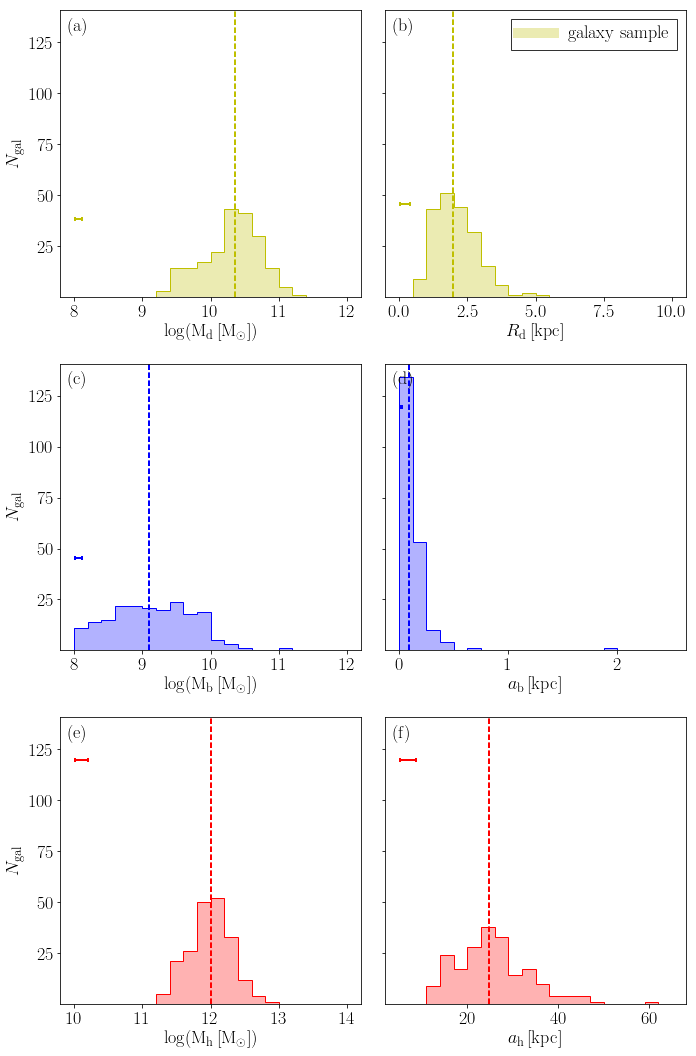

In [8]:
fig, axarr = plt.subplots(3,2,figsize=(10,15),sharey=True)

xlabels = ('$\log(\mathrm{M_d} \, [\mathrm{M_\odot}])$',
           '$R_\mathrm{d} \, [\mathrm{kpc}]$',
           '$\log(\mathrm{M_b} \, [\mathrm{M_\odot}])$',
           '$a_\mathrm{b} \, [\mathrm{kpc}]$',
           '$\log(\mathrm{M_h} \, [\mathrm{M_\odot}])$',
           '$a_\mathrm{h} \, [\mathrm{kpc}]$')

letters = 'abcdef'

for ax in axarr[:,0]:
    ax.set_ylabel('$N_\mathrm{gal}$')
    
axarr = axarr.ravel()

for ax, d, xlabel,letter in zip(axarr,data,xlabels,letters):
    plt.sca(ax)
    _ = d.histogram(ax)
    _ = d.median_line(ax,True,lw=2,linestyle='dashed')
    _ = d.uncertainty_bar(ax)
    _ = ax.set_xlabel(xlabel)
    _ = ax.text(0.025,0.975,'({})'.format(letter),
                transform=ax.transAxes,ha='left',va='top')
    
_ = fig.tight_layout()

_ = axarr[1].plot([],[],color='y',lw=10,alpha=0.3,label='galaxy sample')
#_ = axarr[1].plot([],[],color='k',lw=3,label=r'stars + H\textsc{i}')
_ = axarr[1].legend(loc='upper right',
                    edgecolor='k',fancybox=False)

#fig.savefig('figures/parameter_histograms.pdf')

In [9]:
def get_halo_table(halos):

    halo_table = Table()

    halo_table['M_disc_stars'] = halos.disc_mass(hi=False).data
    halo_table['delta_M_disc_stars'] = halos.disc_mass(hi=False).uncertainty.array

    halo_table['M_disc_total'] = halos.disc_mass(hi=True).data
    halo_table['delta_M_disc_total'] = halos.disc_mass(hi=True).uncertainty.array

    halo_table['R_disc_stars'] = halos.stellar_disc_scale_length().data
    halo_table['delta_R_disc_stars'] = halos.stellar_disc_scale_length().uncertainty.array

    halo_table['R_disc_total'] = halos.disc_scale_length().data
    halo_table['delta_R_disc_total'] = halos.disc_scale_length().uncertainty.array

    halo_table['M_bulge'] = halos.bulge_mass().data
    halo_table['delta_M_bulge'] = halos.bulge_mass().uncertainty.array

    halo_table['R_bulge'] = halos.bulge_scale_length().data
    halo_table['delta_R_bulge'] = halos.bulge_scale_length().uncertainty.array

    halo_table['M_halo'] = halos.halo_mass().data
    halo_table['delta_M_halo'] = halos.halo_mass().uncertainty.array

    halo_table['R_halo'] = halos.halo_scale_length()[1].data
    halo_table['delta_R_halo'] = halos.halo_scale_length()[1].uncertainty.array

    r_d = [1,1.5,2,2.2]
    for r in r_d:
        m_hernquist_pred = halos.m_predicted(y=r/2,halo='hernquist')
        m_burkert_pred = halos.m_predicted(y=r/2,halo='burkert')
        halo_table['m_hernquist_{}R_d'.format(r)] = m_hernquist_pred['m']

        halo_table['m_burkert_{}R_d'.format(r)] = m_burkert_pred['m']
        
    halo_table['M_disc_stars_2.2'] = halos.M_disc_22(False).data
    halo_table['delta_M_disc_stars_2.2'] = halos.M_disc_22(False).uncertainty.array
    
    halo_table['M_disc_total_2.2'] = halos.M_disc_22(True).data
    halo_table['delta_M_disc_total_2.2'] = halos.M_disc_22(True).uncertainty.array
    
    halo_table['M_bulge_2.2'] = halos.M_bulge_22().data
    halo_table['delta_M_bulge_2.2'] = halos.M_bulge_22().uncertainty.array
    
    halo_table['M_halo_2.2_hernquist'] = halos.M_halo_22_hernquist().data
    halo_table['delta_M_halo_2.2_hernquist'] = halos.M_halo_22_hernquist().uncertainty.array
    
    halo_table['M_halo_2.2_burkert'] = halos.M_halo_22_burkert().data
    halo_table['delta_M_halo_2.2_burkert'] = halos.M_halo_22_burkert().uncertainty.array
    
    halo_table['Gamma_hernquist'] = halos.total_shear('hernquist').data
    halo_table['delta_Gamma_hernquist'] = halos.total_shear('hernquist').uncertainty.array
    
    halo_table['Gamma_burkert'] = halos.total_shear('burkert').data
    halo_table['delta_Gamma_burkert'] = halos.total_shear('burkert').uncertainty.array

    halo_table['psi_hernquist'] = halos.psi_predicted('hernquist').data
    halo_table['delta_psi_hernquist'] = halos.psi_predicted('hernquist').uncertainty.array
    
    halo_table['psi_burkert'] = halos.psi_predicted('burkert').data
    halo_table['delta_psi_burkert'] = halos.psi_predicted('burkert').uncertainty.array
    
    return halo_table

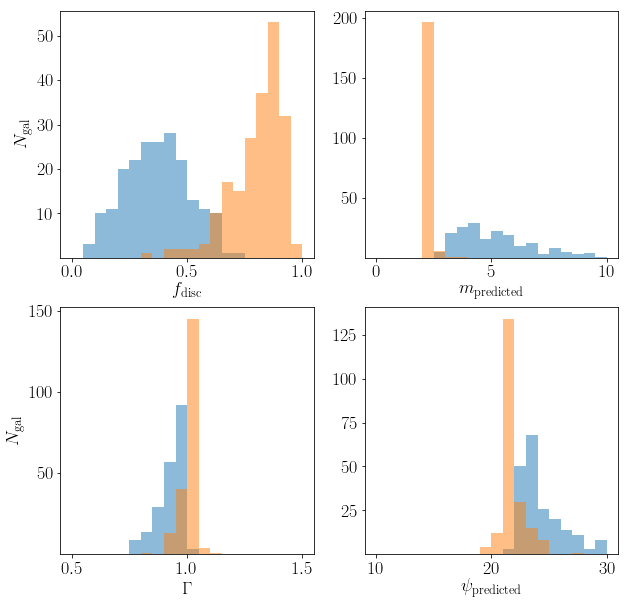

In [10]:
halo_table = get_halo_table(halos)

f_bins = np.linspace(0,1,21)
m_bins = np.linspace(0,10,21)
psi_bins = np.linspace(10,30,21)
Gamma_bins = np.linspace(0.5,1.5,21)

fig, axarr = plt.subplots(2,2,figsize=(10,10))
axarr = axarr.ravel()

f_disc_hernquist = (halo_table['M_disc_stars_2.2']
                 / (halo_table['M_disc_stars_2.2'] 
                  + halo_table['M_bulge_2.2'] 
                  + halo_table['M_halo_2.2_hernquist']))

f_disc_burkert = (halo_table['M_disc_stars_2.2']
                 / (halo_table['M_disc_stars_2.2'] 
                  + halo_table['M_bulge_2.2'] 
                  + halo_table['M_halo_2.2_burkert']))

_ = axarr[0].hist(f_disc_hernquist,f_bins,alpha=0.5)
_ = axarr[0].hist(f_disc_burkert,f_bins,alpha=0.5)
_ = axarr[0].set_xlabel('$f_\mathrm{disc}$')
_ = axarr[0].set_ylabel('$N_\mathrm{gal}$')

_ = axarr[1].hist(halo_table['m_hernquist_2R_d'],m_bins,alpha=0.5)
_ = axarr[1].hist(halo_table['m_burkert_2R_d'],m_bins,alpha=0.5)
_ = axarr[1].set_xlabel('$m_\mathrm{predicted}$')

_ = axarr[2].hist(halo_table['Gamma_hernquist'],Gamma_bins,alpha=0.5)
_ = axarr[2].hist(halo_table['Gamma_burkert'],Gamma_bins,alpha=0.5)
_ = axarr[2].set_xlabel('$\Gamma$')
_ = axarr[2].set_ylabel('$N_\mathrm{gal}$')

_ = axarr[3].hist(halo_table['psi_hernquist'],psi_bins,alpha=0.5)
_ = axarr[3].hist(halo_table['psi_burkert'],psi_bins,alpha=0.5)
_ = axarr[3].set_xlabel('$\psi_\mathrm{predicted}$')

In [11]:
halo_table_all = Table()
for c in halo_table.colnames:
    halo_table_all[c] = np.full(len(galaxy_data),-999,dtype='float64')
    halo_table_all[c][sample] = halo_table[c]

halo_table_all['id'] = galaxy_data['object']
halo_table_all['mask'] = sample

halo_table.write('s4g_fits/halo_table.fits',overwrite=True)
halo_table_all.write('s4g_fits/halo_table_all.fits',overwrite=True)